In [12]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from sippy import *
import plots

In [13]:
# Load spteptest data from a TSV file
file = r'..\data\PC_DATA_GBN_RW_Test.csv'
step_test_data = pd.read_csv(file,index_col='Time', parse_dates=True, skiprows=[1,2])
ts = pd.Timedelta(step_test_data.index[1] - step_test_data.index[0]).total_seconds() # data sampling time
step_test_data.head()

,Fuel,Fan,Feed,Temp,O2
Time,,,,,
2012-01-05 15:12:00,13.333666,99.634463,109.511249,891.610797,10.142248
2012-01-05 15:12:10,13.333716,99.938583,108.589265,891.590748,10.004502
2012-01-05 15:12:20,13.333766,102.672416,108.588081,891.649059,9.947349
2012-01-05 15:12:30,13.333817,102.672822,109.507697,891.671557,10.136670
2012-01-05 15:12:40,13.333867,102.673228,110.427313,891.655137,10.399598


In [14]:
# slice data for model identification case
start = '2012-01-05 23:14:10'
stop = '2012-01-06 10:55:50'
idinput = step_test_data.loc[start:stop].copy()

# get time stamp for ploting
Time = idinput.index

In [15]:
# select Inputs and Outputs for the model identification case
inputs = ['Fuel','Fan', 'Feed']
outputs = ['Temp','O2']

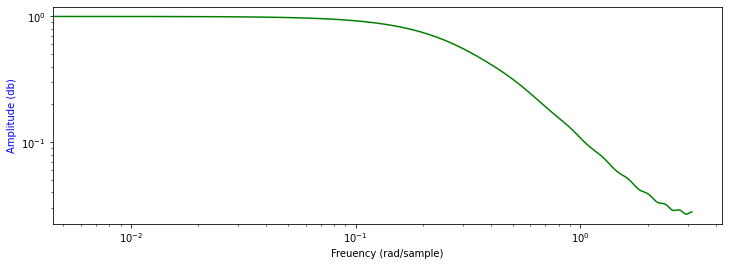

In [16]:
# prepare detrending filter 
tss = 5 * 60
mult_factor = 3
filt_tss = tss * mult_factor
numtaps = 32+1
cutoff = 2/filt_tss/mult_factor
fs = ts
pass_zero= 'lowpass'
window = ('exponential', None, 3)
coef = signal.firwin(numtaps=numtaps, cutoff=cutoff, window=window, pass_zero=pass_zero, fs=fs)
plots.plot_freuency_response(coef)

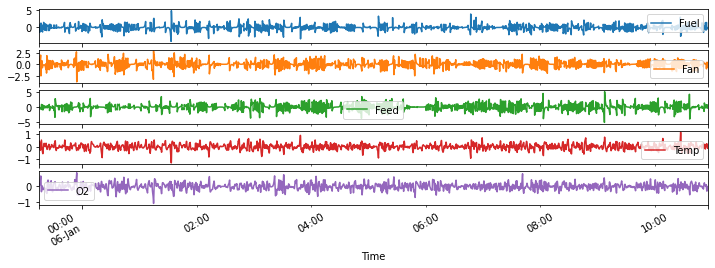

In [17]:
# Detrend signal and plot
trend = signal.filtfilt(coef, 1.0,idinput, axis=0)
idinput = idinput - trend
idinput.plot(subplots=True)
plt.show()

In [18]:
# Convert dataframe to numpy array in the shape requied for SIPPY
u = idinput[inputs].to_numpy().T
y = idinput[outputs].to_numpy().T
print('Output shape:', y.shape)
print('Input shape:',u.shape)

Output shape: (2, 4211)
Input shape: (3, 4211)


In [19]:
# Specify model identification parameters, reffer the documentation for detais.
model = 'Precalciner.npz' #model file name
method='CVA' #ID nethod; refer SIPPY doc
IC = 'AIC' # None, AIC, AICc, BIC
TH = 30 # The length of time horizon used for regression
fix_ordr = 8 # Used if and only if IC = 'None'
max_order = 25 # Used if IC = AIC, AICc or BIC
req_D = False
force_A_stable = False

In [20]:
sys_id = system_identification(
    y, 
    u, 
    method,
    SS_fixed_order=fix_ordr,
    SS_max_order=max_order,
    IC=IC,
    SS_f=TH,
    SS_p=TH,
    SS_D_required=req_D,
    SS_A_stability=force_A_stable
    )
#save model parameters A, B, C,D and X0 as npz file
np.savez(model, A=sys_id.A, B=sys_id.B, C=sys_id.C, D=sys_id.D, K=sys_id.K, X0=sys_id.x0)

The suggested order is: n= 4


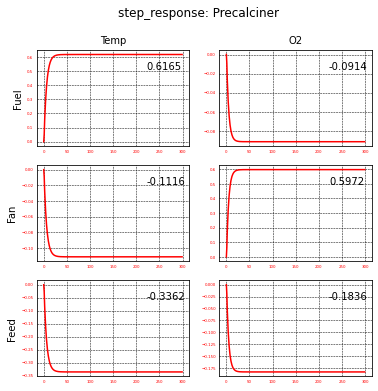

In [21]:
plots.plot_model(model, inputs, outputs, tss=tss)

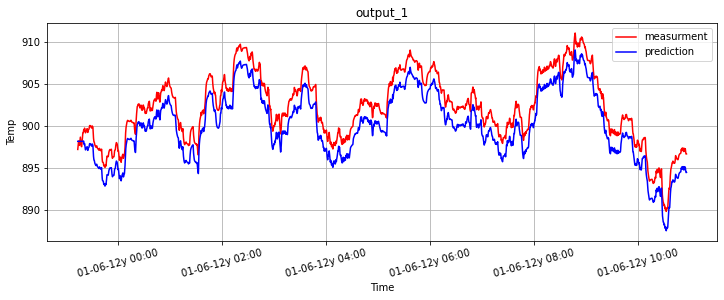

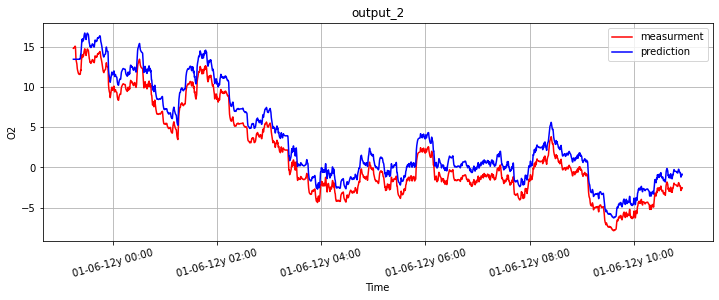

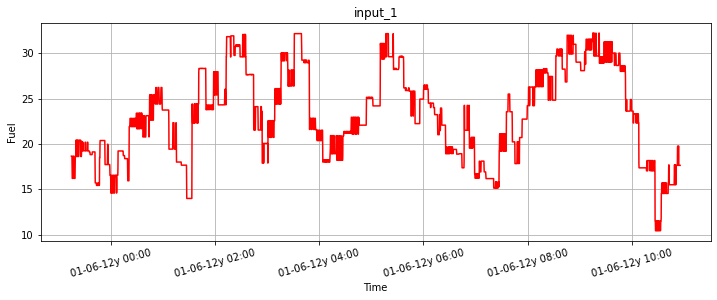

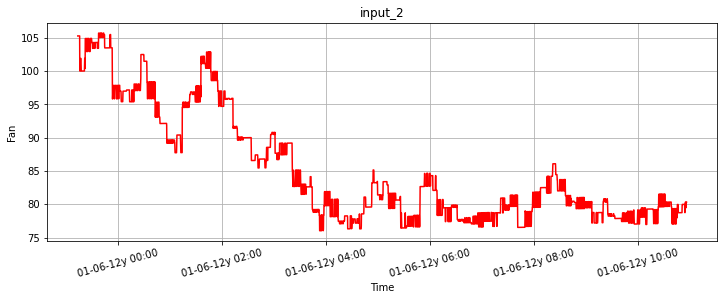

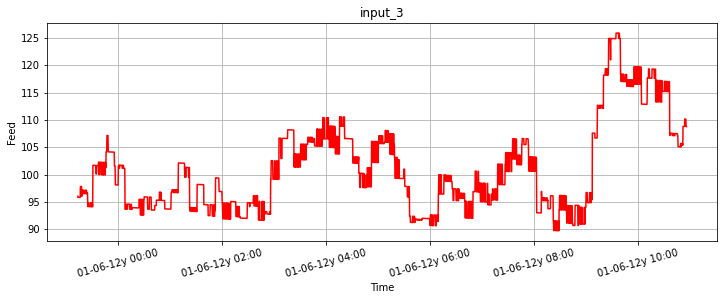

In [22]:
start_time = start
end_time = stop
plots.plot_comparison(step_test_data, model, inputs, outputs, start_time, end_time, plt_input=True)